In [102]:
%load_ext autoreload
%autoreload 2

from src.utils import load_json, save_json
import pandas as pd
import re
from itertools import chain
from collections import defaultdict
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Update 24310 up pull with ec numbers

In [44]:
# Add ECs back 

old = pd.read_csv(
    '/home/stef/bottle/data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv',
    sep='\t'
)

old.set_index('Entry', inplace=True)

new = pd.read_csv(
    '/home/stef/bottle/data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_07_29.tsv',
    sep='\t'
)

new.set_index('Entry', inplace=True)

In [45]:
new.head()

,EC number
Entry,
A0A009IHW8,3.2.2.-; 3.2.2.6
A0A023I7E1,3.2.1.39
A0A024B7W1,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,3.1.1.74
A0A024SH76,3.2.1.91


In [46]:
old.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [47]:
select = [elt for elt in old.index if elt in new.index]
old.loc[select, "EC number"] = new.loc[select, 'EC number']
old.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [34]:
# old.to_csv(
#     '/home/stef/bottle/data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv',
#     sep='\t'
# )

In [37]:
len(select), len(old)

(254291, 254456)

# Get list of rhea ids w/ smarts from combo of UP pull and Rhea flat files

In [64]:
# Rhea flat files and UP pull

rhea_directions = pd.read_csv('/home/stef/bottle/data/sprhea/rhea-directions.tsv', '\t')
rhea_smarts = pd.read_csv('/home/stef/bottle/data/sprhea/rhea-reaction-smiles.tsv', '\t', header=None)
rhea_smarts.columns = ["rhea_id", "smarts"]
rhea_smarts.set_index('rhea_id', inplace=True)
rhea_uniprot = pd.read_csv('/home/stef/bottle/data/sprhea/rhea2uniprot_sprot.tsv', sep='\t')
up_pull = pd.read_csv('/home/stef/bottle/data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv', sep='\t')
up_pull.set_index("Entry", inplace=True)

/home/stef/miniconda3/envs/mine/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [65]:
# Rhea IDs w smarts are a subset of all ids in rhea-directions

rhea_all = set()
for col in rhea_directions.columns:
    rhea_all = rhea_all | set(rhea_directions.loc[:, col])
w_smarts = set(rhea_smarts.index.values)
w_smarts - rhea_all

set()

In [66]:
# Only rhea IDs in LR & RL columns of rhea directions have a smarts entry, and if there is one there are both!

codes = []
counts = []
for i, row in rhea_directions.iterrows():
    ct = 0
    code = ''
    for id in row:
        if id in w_smarts:
            ct += 1
            code += '1'
        else:
            code += '0'
    counts.append(ct)
    codes.append(code)

print(set(counts))
print(rhea_directions.columns)
print(set(codes))

{0, 2}
Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
{'0000', '0110'}


In [67]:
# Create look up of (LR, RL) rhea ids from not LR, RL

lookup_directed_ids = {}

for i, row in rhea_directions.iterrows():
    lookup_directed_ids[row['RHEA_ID_MASTER']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])
    lookup_directed_ids[row['RHEA_ID_BI']] = (row['RHEA_ID_LR'], row['RHEA_ID_RL'])

In [68]:
# Get rhea ids UniProt pull

rhea_up_pairs_pull= set()
pattern = r'RHEA:(\d{1,6})' # Regular expression pattern
no_matches = []

for entry, row in up_pull.iterrows():
    cat_act = row["Catalytic activity"]
    if pd.isna(cat_act):
        no_matches.append(entry)
    else:
        matches = re.findall(pattern, cat_act)

        for match in matches:
            rhea_up_pairs_pull.add((int(match), entry))

        if len(matches) == 0:
            no_matches.append(entry)

In [69]:
# Pull rhea-up pairs from rhea's tsv

rhea_up_pairs_flat = set()
for i, row in rhea_uniprot.iterrows():
    rhea_up_pairs_flat.add((row['RHEA_ID'], row['ID']))

In [70]:
# Difference between uppull and rhea pairs is small
len(rhea_up_pairs_flat ^ rhea_up_pairs_pull) / len(rhea_up_pairs_flat | rhea_up_pairs_pull)

0.006352646521386967

In [71]:
# Filter by smarts avail

def filter_pairs_by_smarts(pair):
    r = pair[0]
    if r in w_smarts:
        return True
    elif r in lookup_directed_ids:
        if lookup_directed_ids[r][0] in w_smarts or lookup_directed_ids[r][1] in w_smarts:
            return True
        else:
            return False
    else:
        return False

rhea_up_pairs_pull_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_pull)))
rhea_up_pairs_flat_w_smarts = set(filter(filter_pairs_by_smarts, list(rhea_up_pairs_flat)))

In [72]:
# After filtering by avail of smarts, the difference in rhea-upid pairs
# gotten by the two methods is even smaller

len(rhea_up_pairs_pull_w_smarts ^ rhea_up_pairs_flat_w_smarts) / len(rhea_up_pairs_flat_w_smarts | rhea_up_pairs_pull_w_smarts)

0.005960904846727906

In [73]:
# Translate rhea ids into LR or RL ids since these are the only ones with smarts

pairs_w_smarts = rhea_up_pairs_pull_w_smarts | rhea_up_pairs_flat_w_smarts
translated_pairs_w_smarts = set()
for r, p in pairs_w_smarts:
    if r in w_smarts: # Was already in LR / RL
        translated_pairs_w_smarts.add((r, p))
    elif r not in lookup_directed_ids: # Was not and can't find LR/RL in lookup
        continue
    else: # Was not but found in lookup
        if lookup_directed_ids[r][0] in w_smarts: # Found LR in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][0], p))
        if lookup_directed_ids[r][1] in w_smarts: # Found RL in w smarts
            translated_pairs_w_smarts.add((lookup_directed_ids[r][1], p))


In [79]:
_, old_way_upids = list(zip(*rhea_up_pairs_pull_w_smarts))
old_way_upids = set(old_way_upids)
_, new_way_upids = list(zip(*translated_pairs_w_smarts))
new_way_upids = set(new_way_upids)

In [80]:
net_gain_upids = new_way_upids - old_way_upids
print(len(net_gain_upids))

514


In [83]:
# Save to scrape smi-name pairs from website

rheas_to_get, _ = list(zip(*translated_pairs_w_smarts))
rheas_to_get = list(set(rheas_to_get))

with open("../data/sprhea/rheas_to_get_names.txt", 'w') as f:
    for elt in rheas_to_get:
        f.write(f"{elt}\n")

print(len(rheas_to_get))

24044


In [60]:
len(translated_pairs_w_smarts)

593046

In [84]:
# Save all rhea-uniprot pairs from pull and flat file 
# that have smarts

rhea2uniprot = defaultdict(set)
for r,p in translated_pairs_w_smarts:
    rhea2uniprot[int(r)].add(p)

for k, v in rhea2uniprot.items():
    rhea2uniprot[k] = list(v)

print(len(rhea2uniprot))

save_json(rhea2uniprot, "../data/sprhea/rhea2uniprot_all.json")

24044


In [118]:
# Found smi-name pairs for most reactions

# rhea_smi_name = load_json('/home/stef/bottle/data/sprhea/rhea_smiles_names.json')
# print(len(rhea_smi_name))

# rhea2smi2name = defaultdict(lambda : defaultdict())
# for rid, elt in rhea_smi_name.items():
#     if elt is None:
#         continue
#     for side in ['left', 'right']:
#         for pair in elt[side]:
#             rhea2smi2name[rid][pair['smiles']] = pair['label']
# print(len(rhea2smi2name))

24044
24028


In [58]:
# Count number of smiles in rxn smarts

smiles_from_smarts = set()
for i,row in rhea_smarts.iterrows():
    this_smiles = list(chain(*[elt.split('.') for elt in row['smarts'].split('>>')]))
    for smi in this_smiles:
        smiles_from_smarts.add(smi)

smiles_from_smarts = list(smiles_from_smarts)
print(len(smiles_from_smarts))

12272


# Spot check extracted rhea

In [ ]:
krsv2 = load_json('/home/stef/bottle/data/mapping/known_rxns_swissprot_enzymes_240310_v2.json')
len(krsv2)


In [101]:
# Similar amount of reactions to v2

krsv3 = load_json('/home/stef/bottle/data/sprhea/sprhea_240310_v3.json')
krsv3 = {int(k) : v for k,v in krsv3.items()}
len(krsv3)

19602

In [42]:
rxnid = -1

In [60]:
# Spot checks

rxnid += 1
print(rxnid)
krsv3[rxnid]


15


{'smarts': '*C(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(*)=O.O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1>>*C(=O)OCC(CO)OC(*)=O.O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1',
 'min_rule': None,
 'imt_rules': None,
 'smi2name': {'*C(=O)OCC(COC1OC(CO)C(O)C(O)C1O)OC(*)=O': 'a 1,2-diacyl-3-O-(beta-D-glucopyranosyl)-sn-glycerol;a 1,2-diacyl-3-O-(beta-D-galactosyl)-sn-glycerol;a 1,2-diacyl-3-O-(alpha-D-glucopyranosyl)-sn-glycerol',
  'O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)O)C(O)C2O)c(=O)[nH]1': 'UDP',
  '*C(=O)OCC(CO)OC(*)=O': 'a 1,2-diacyl-sn-glycerol',
  'O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1': 'UDP-alpha-D-glucose;UDP-alpha-D-galactose'},
 'enzymes': [{'uniprot_id': 'B7H9Q4',
   'sequence': 'MIKNPKVLILTAHYGNGHVQVAKTLEQTFRQKGIEDVIVCDLFGESHPFITDITKYLYLKSYTIGKELYRLFYYGVEKIYDKKIASWYANFGRKRLKTLLQVEKPDIVINTFPIIAVPELKKQTGISIPVYNVLTDFCVHKIWIHREVDRYFVATDHVKELMVDIGVPAEQIVETGIPIRSSFELKVNPEIIYTKYQLCKNKKILLIVAGAHGVLGNVKELCQSFMSVPNLQIVVVCGKNEALKQDLL

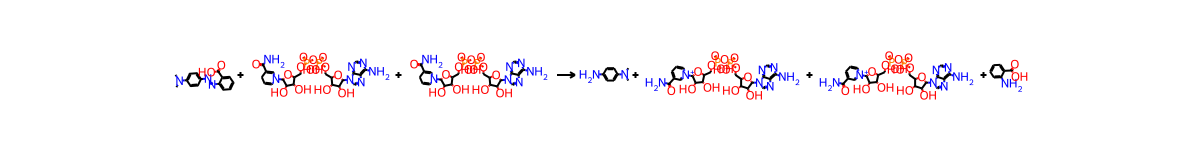

In [50]:

AllChem.ReactionFromSmarts(krsv3[rxnid]['smarts'], useSmiles=True)

In [62]:
print(standardize_smiles('C=CC1=C(C)/C2=C/C3=C(C=C)C(C)=C4/C=C5/C(C)=C(CCC(=O)[O-])C6=[N+]5[Fe-2]5(N43)N3C(=C6)C(CCC(=O)[O-])=C(C)/C3=C/C1=[N+]25', True))
print(standardize_smiles("CC1=C(CCC([O-])=O)C2=[N+]3C1=Cc1c(C)c(C=C)c4C=C5C(C)=C(C=C)C6=[N+]5[Fe--]3(n14)n1c(=C6)c(C)c(CCC([O-])=O)c1=C2", True))
print('C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C')

[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Removed covalent bond between Fe and N
[09:26:37] Initializing Normalizer
[09:26:37] Running Normalizer
[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Initializing Normalizer
[09:26:37] Running Normalizer
[09:26:37] Running LargestFragmentChooser
[09:26:37] Fragment: C=CC1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)[O-])C(CCC(=O)[O-])=C4C)c(C)c3C=C
[09:26:37] New largest fragment: C=CC1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)[O-])C(CCC(=O)[O-])=C4C)c(C)c3C=C (72)
[09:26:37] Fragment: [Fe+2]
[09:26:37] Tautomer enumeration stopped at 364 tautomers: max transforms reached
[09:26:37] Initializing MetalDisconnector
[09:26:37] Running MetalDisconnector
[09:26:37] Removed covalent bond between Fe a

C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C
C=CC1=C(C)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)=C(C)C5=CCC(=O)O)c(CCC(=O)O)c4C)c(C)c3=CC
C=C1C(=CC)c2cc3[nH]c(cc4[nH]c(cc5nc(cc1n2)C(CC)=C5C)c(C)c4CCC(=O)O)c(C=CC(=O)O)c3C


[09:26:38] Tautomer enumeration stopped at 410 tautomers: max transforms reached


In [51]:
# Check reverses are correct

norev = []
for k,v in krsv3.items():
    smarts = v['smarts']
    rev = v['reverse']
    assert rev is not None
    rev_smarts = smarts.split('>>')[1] + ">>" + smarts.split('>>')[0]
    assert rev_smarts == krsv3[rev]['smarts']

In [76]:
# Check for transport reactions
trans = []
for k,v in krsv3.items():
    if v['reverse'] == k:
        trans.append(k)
print(len(trans))

# Add in operator mappings

In [108]:
n_chunks = 20

tmp = []
for i in range(n_chunks):
    path = f"../artifacts/operator_mapping_sprhea_v3_min_ops_part_{i}.tsv"
    tmp.append(
        pd.read_csv(
            filepath_or_buffer=path,
            sep='\t'
        ).set_index("Reaction ID")
    )

map_res = pd.concat(tmp)
map_res.head()

FileNotFoundError: [Errno 2] No such file or directory: '../artifacts/operator_mapping_sprhea_v3_min_ops_part_16.tsv'

# Handle subunits

In [2]:
path = "../data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv"
df = pd.read_csv(path, sep='\t')
df.set_index("Entry", inplace=True)
df.head()

,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
A0A009IHW8,reviewed,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),Evidence at protein level,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,CATALYTIC ACTIVITY: Reaction=NAD(+) = 2'cADPR ...,3.2.2.-; 3.2.2.6
A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,Evidence at protein level,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.39
A0A024B7W1,reviewed,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,Evidence at protein level,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,CATALYTIC ACTIVITY: [RNA-directed RNA polymera...,2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...
A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,3.1.1.74
A0A024SH76,reviewed,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,Evidence at protein level,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,3.2.1.91


In [3]:
len(df)

254456

In [4]:
nanless = df.loc[~df['Protein names'].isna()]
subunits = nanless.loc[nanless['Protein names'].str.contains('subunit')].sort_values(by='Protein names')

In [8]:
print(len(subunits))
subunits.head()

40097


,Reviewed,Protein names,Organism,Protein existence,Sequence,Catalytic activity,EC number
Entry,,,,,,,
Q1QWP1,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MSIDFVVHDADDAVGVVVVEGVEAGQMLTGWVMDQDRTLQFEVKDA...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y44,reviewed,(2R)-sulfolactate sulfo-lyase subunit alpha (E...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MLCVVTSDNSDFRLTAKADIPIGHKVALKALKAGDTVIKYHEDIGK...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q58Y43,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Paracoccus pantotrophus (Thiosphaera pantotropha),Evidence at protein level,MALDFSNATVKAWRRENGRVGVRNHVLILPVDDISNAACEAVANNV...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q1QWP0,reviewed,(2R)-sulfolactate sulfo-lyase subunit beta (EC...,Chromohalobacter salexigens (strain ATCC BAA-1...,Evidence at protein level,MELKGRTFLGYRRDNGRVGIRNHVIVLPVDDISNAAAEAVANNIKG...,CATALYTIC ACTIVITY: Reaction=(2R)-3-sulfolacta...,4.4.1.24
Q9KJF1,reviewed,(2S)-[(R)-hydroxy(phenyl)methyl]succinyl-CoA d...,Thauera aromatica,Evidence at protein level,MGIQNRVALITGSASGMGKQTALRFAEQGAAVVINDIDAEKVRATV...,CATALYTIC ACTIVITY: Reaction=(2S)-[(R)-hydroxy...,1.1.1.429


In [6]:
subunits.to_csv('../data/sprhea/subunits_240310.tsv', sep='\t')

In [9]:
selector = (subunits['Protein existence'] == 'Evidence at protein level') | (subunits['Protein existence'] == 'Evidence at transcript level')
len(subunits.loc[selector])

4655

In [10]:
j = 0
for i, row in subunits.iterrows():
    print(i, row['Protein names'])
    j += 1

    if j > 50:
        break

Q1QWP1 (2R)-sulfolactate sulfo-lyase subunit alpha (EC 4.4.1.24) (Sulfolactate sulfo-lyase A)
Q58Y44 (2R)-sulfolactate sulfo-lyase subunit alpha (EC 4.4.1.24) (Sulfolactate sulfo-lyase A)
Q58Y43 (2R)-sulfolactate sulfo-lyase subunit beta (EC 4.4.1.24) (Sulfolactate sulfo-lyase B)
Q1QWP0 (2R)-sulfolactate sulfo-lyase subunit beta (EC 4.4.1.24) (Sulfolactate sulfo-lyase B)
Q9KJF1 (2S)-[(R)-hydroxy(phenyl)methyl]succinyl-CoA dehydrogenase subunit BbsD (EC 1.1.1.429) ((S,R)-2-(alpha-hydroxybenzyl)succinyl-CoA dehydrogenase subunit BbsD)
Q9XT00 (3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1.n12) (17-beta-hydroxysteroid dehydrogenase 8) (17-beta-HSD 8) (3-ketoacyl-[acyl-carrier-protein] reductase alpha subunit) (KAR alpha subunit) (3-oxoacyl-[acyl-carrier-protein] reductase) (Estradiol 17-beta-dehydrogenase 8) (EC 1.1.1.62) (Protein Ke6) (Ke-6) (Testosterone 17-beta-dehydrogenase 8) (EC 1.1.1.239)
P50171 (3R)-3-hydroxyacyl-CoA dehydrogenase (EC 1.1.1.n12) (17-beta-hydroxysteroid dehydrogenas

In [35]:
path = "../data/sprhea/uniprotkb_reviewed_true_AND_proteins_wi_2024_02_29.tsv"
df = pd.read_csv(path, sep='\t')
df.set_index("Entry", inplace=True)
df.head()

whitelist = ['Evidence at protein level', 'Evidence at transcript level', 'Inferred from homology']
all_v3_upid = set()
for k,v in krsv3.items():
    for e in v['enzymes']:
        if e['existence'] in whitelist:
            all_v3_upid.add(e['uniprot_id'])

print(len(all_v3_upid))
# id_seq = df.loc[all_v3_upid, ['Sequence']]

# id_seq.to_csv(
#     "../artifacts/sprhea_v3_all_upids.tsv",
#     sep='\t'
# )

# load = pd.read_csv(
#     "../artifacts/sprhea_v3_all_upids.tsv",
#     sep='\t'
# )
# load.head()

206659
